# Import modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import colormaps
from datetime import timedelta
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy.stats import linregress

# Absorbance curves over time

## Initial plot

Background: ./20250527_exp1\Background_27052025_FLMS018081_09-55-18-633.txt, I_background.shape = (2022,)
Reference: ./20250527_exp1\Reference_27052025_FLMS018081_09-56-34-581.txt, I_ref.shape = (2022,)
145


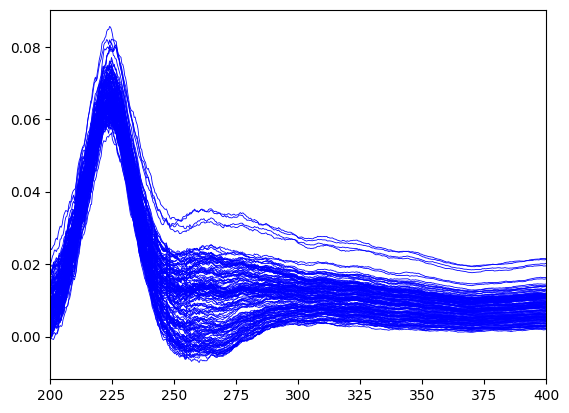

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import glob

# exp_folder = './20250626_exp2'
exp_folder = './20250527_exp1'

skip = 40

for file in glob.glob(f'{exp_folder}/*.txt'):
    if 'Background' in file: 
        x, I_background = np.loadtxt(file,skiprows=skip,usecols=(0,1),unpack=True)
        print(f"Background: {file}, I_background.shape = {I_background.shape}")
    if 'Reference' in file: 
        x, I_ref = np.loadtxt(file,skiprows=skip,usecols=(0,1),unpack=True)
        print(f"Reference: {file}, I_ref.shape = {I_ref.shape}")

count = 0

for file in glob.glob(f'{exp_folder}/*.txt'):
    if 'Reference' not in file and 'Background' not in file: 
        x, I = np.loadtxt(file,skiprows=skip,usecols=(0,1),unpack=True)
        # print(f"Absorbance: {file}, I.shape = {I.shape}")
        abs = -np.log10((I - I_background)/(I_ref - I_background))
        plt.plot(x,abs,'b-',lw=0.6)
        count += 1

# x, I = np.loadtxt(f'{exp_folder}/24HourExp_27052025_FLMS018081_10-08-22-355.txt',usecols=(0,1),skiprows=skip,unpack=True)
# abs = -np.log10((I - I_background)/(I_ref - I_background))
# plt.plot(x, abs, 'k-')

# x, I = np.loadtxt(f'{exp_folder}/24HourExp_27052025_FLMS018081_10-48-22-285.txt',usecols=(0,1),skiprows=skip,unpack=True)
# abs = -np.log10((I - I_background)/(I_ref - I_background))
# plt.plot(x, abs, 'r-')

print(count)
    
plt.xlim(200.0,400.0)
plt.show()

## Processing and setup

In [7]:
skip = 40
exp_folder = './20250527_exp1'

# extracting timestamp
def extract_time_seconds(filename):
    time_str = filename.split('_')[-1].replace('.txt', '')
    h, m, s, ms = map(int, time_str.split('-'))
    return h * 3600 + m * 60 + s + ms / 1000.0

# sort by time
exp_files = [file for file in glob.glob(f'{exp_folder}/*.txt') if '24HourExp' in file]
exp_files.sort(key=lambda f: extract_time_seconds(os.path.basename(f)))
times = [extract_time_seconds(os.path.basename(f)) for f in exp_files]

# Colormap
norm = Normalize(vmin=min(times), vmax=max(times))
cmap = colormaps['inferno']

# background and reference
I_background = I_ref = None
for file in glob.glob(f'{exp_folder}/*.txt'):
    if 'Background' in file:
        x, I_background = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    elif 'Reference' in file:
        x, I_ref = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)

## Colour-coded 
Plotting all curves over time, colour coded to see time progression.

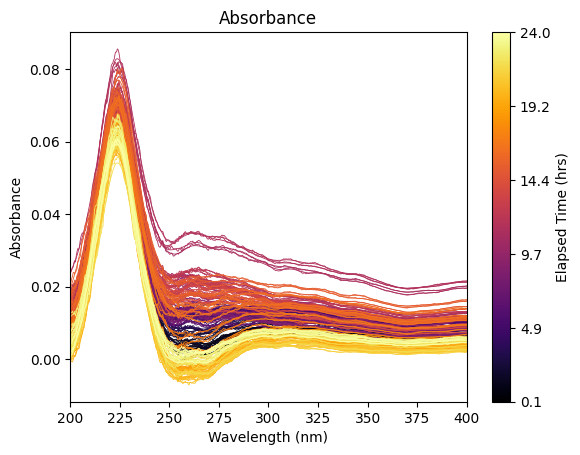

Total plotted: 145


In [9]:
fig, ax = plt.subplots()

# === Plot all absorbance traces with time-color
for i, (file, t) in enumerate(zip(exp_files, times)):
    x, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    ab = -np.log10((I - I_background) / (I_ref - I_background))
    ax.plot(x, ab, color=cmap(norm(t)), lw=0.6)
    
    #### SMOOTHING
    # Savitzky-Golay smoothing
    window_length = min(51, len(ab) // 2 * 2 + 1)  # must be odd and less than data length
    ab_smooth = savgol_filter(ab, window_length=window_length, polyorder=3)

    ax.plot(x, ab_smooth, color=cmap(norm(t)), lw=0.6)
    
# === Plot background and reference
# ax.plot(x, -np.log10((I_background - I_background)/(I_ref - I_background)), color='blue', lw=1.5, label='Background')
# ax.plot(x, -np.log10((I_ref - I_background)/(I_ref - I_background)), color='black', lw=1.5, label='Reference')

# === Colorbar: Time progression
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=ax, label='Elapsed Time (hrs)')
tick_vals = np.linspace(min(times), max(times), 6)
tick_labels = [f"{t/3600:.1f}" for t in tick_vals]
cbar.set_ticks(tick_vals)
cbar.set_ticklabels(tick_labels)

# === Final touches
plt.xlim(200.0,400.0)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Absorbance')
ax.set_title('Absorbance')
# ax.legend()
plt.show()

print(f"Total plotted: {len(exp_files)}")

## Normalised to 400 nm value (400 nm = 1)

Attempt 1: Setting the 400 nm value to 1 (NOT USING)

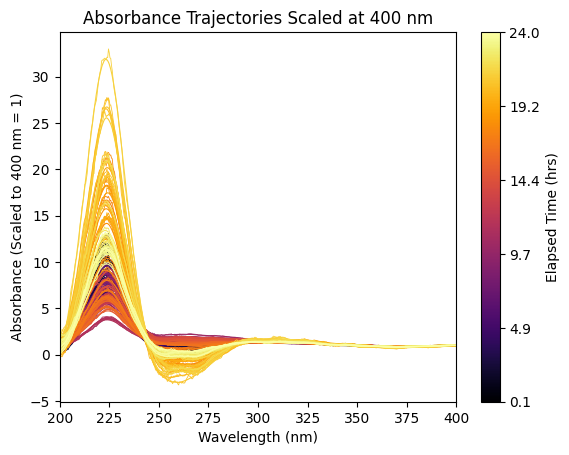

In [12]:
fig, ax = plt.subplots()
norm = Normalize(vmin=min(times), vmax=max(times))
cmap = colormaps['inferno']

# Find index closest to 400 nm
idx_400 = np.argmin(np.abs(x - 400))

# Plot scaled absorbance traces
for file, t in zip(exp_files, times):
    x, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    ab = -np.log10((I - I_background) / (I_ref - I_background))
    scale_factor = ab[idx_400]
    if scale_factor == 0: continue  # avoid divide-by-zero
    abs_scaled = ab / scale_factor
    ax.plot(x, abs_scaled, color=cmap(norm(t)), lw=0.6)
    
    ######### SMOOTHING
    # Savitzky-Golay smoothing
    # window_length must be odd and less than the length of x
    window_length = min(51, len(abs_scaled) // 2 * 2 + 1)  # dynamically determine suitable window
    abs_scaled_smooth = savgol_filter(abs_scaled, window_length=window_length, polyorder=3)

    ax.plot(x, abs_scaled_smooth, color=cmap(norm(t)), lw=0.8)

# Plot reference and background (scaled)
# bg_abs = -np.log10((I_background - I_background) / (I_ref - I_background))
# ref_abs = -np.log10((I_ref - I_background) / (I_ref - I_background))
# ref_abs_scaled = ref_abs / ref_abs[idx_400]
# ax.plot(x, ref_abs_scaled, 'orange', lw=1.5, label='Reference')
# # background absorbance is undefined, plot as flat zero line
# ax.plot(x, np.zeros_like(x), 'green', lw=1.5, label='Background')

# Add colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=ax, label='Elapsed Time (hrs)')
tick_vals = np.linspace(min(times), max(times), 6)
tick_labels = [f"{t/3600:.1f}" for t in tick_vals]
cbar.set_ticks(tick_vals)
cbar.set_ticklabels(tick_labels)

# Plot settings
plt.xlim(200.0,400.0)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Absorbance (Scaled to 400 nm = 1)')
ax.set_title('Absorbance Trajectories Scaled at 400 nm')
# ax.legend()
plt.show()

## Additive normalisation to 400 nm average

The average value for absorbance at 400 nm is used to shift all curves up or down to match it. 

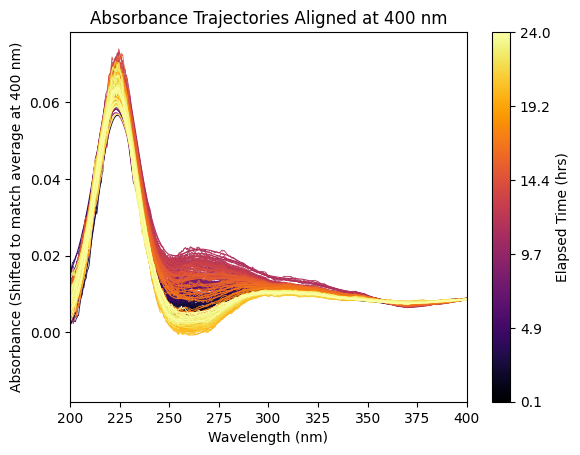

In [15]:
# Find index closest to 400 nm
idx_400 = np.argmin(np.abs(x - 400))

# Prepare absorbance traces and values at 400 nm
abs_traces = []
abs_at_400_list = []

for file in exp_files:
    x, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs_trace = -np.log10((I - I_background) / (I_ref - I_background))
    abs_traces.append(abs_trace)
    abs_at_400_list.append(abs_trace[idx_400])

# Compute average absorbance at 400 nm
avg_abs_400 = np.mean(abs_at_400_list)

# Plot settings
norm = Normalize(vmin=min(times), vmax=max(times))
cmap = colormaps['inferno']
fig, ax = plt.subplots()

# Plot adjusted traces
for abs_trace, t, abs_400 in zip(abs_traces, times, abs_at_400_list):
    shift = avg_abs_400 - abs_400
    abs_shifted = abs_trace + shift
    ax.plot(x, abs_shifted, color=cmap(norm(t)), lw=0.6)
    
    ######### SMOOTHING
    # Apply Savitzky-Golay smoothing
    # window_length must be odd and less than the length of x
    window_length = min(81, len(abs_scaled) // 2 * 2 + 1)  # dynamically determine suitable window
    abs_scaled_smooth = savgol_filter(abs_shifted, window_length=window_length, polyorder=3)

    ax.plot(x, abs_scaled_smooth, color=cmap(norm(t)), lw=0.8)

# Add colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=ax, label='Elapsed Time (hrs)')
tick_vals = np.linspace(min(times), max(times), 6)
tick_labels = [f"{t/3600:.1f}" for t in tick_vals]
cbar.set_ticks(tick_vals)
cbar.set_ticklabels(tick_labels)

# Plot settings
plt.xlim(200.0, 400.0)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Absorbance (Shifted to match average at 400 nm)')
ax.set_title('Absorbance Trajectories Aligned at 400 nm')
plt.show()


# Kinetics

In [17]:
# plot normalisation to 1 or 0
# first derivative - check that still proportional to concentration
# HNCO might form and oxidise --> first step in break down further
# urea protected by products? --> oscillating? 


In [18]:
# # === Extract time from filename ===
# def extract_time_seconds(filename):
#     time_str = filename.split('_')[-1].replace('.txt', '')
#     h, m, s, ms = map(int, time_str.split('-'))
#     return h * 3600 + m * 60 + s + ms / 1000.0

# # === Band averaging function ===
def band_averaged_absorbance(wavelengths, absorbance, center_nm=220, band_half_width=2):
    band_mask = (wavelengths >= center_nm - band_half_width) & (wavelengths <= center_nm + band_half_width)
    if not np.any(band_mask):
        raise ValueError(f"No wavelengths found in specified band around {center_nm} nm.")
    return np.mean(absorbance[band_mask])

## Initial plot

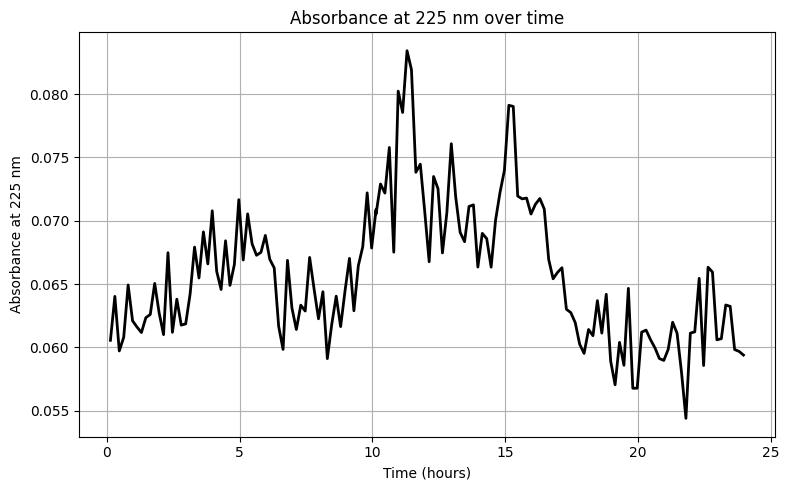

In [20]:
target_wavelength = 225

# find index closest to target
idx = np.argmin(np.abs(x - target_wavelength))

# find absorbance at specified wavelength
times = []
abs_values = []

for file in exp_files:
    x, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs_spectrum = -np.log10((I - I_background) / (I_ref - I_background))
    
    time_seconds = extract_time_seconds(os.path.basename(file))
    times.append(time_seconds / 3600)  # convert to hours
    abs_values.append(abs_spectrum[idx])

# Plot kinetics
plt.figure(figsize=(8, 5))
plt.plot(times, abs_values, '-', color='black', lw=2)
plt.xlabel('Time (hours)')
plt.ylabel(f'Absorbance at {target_wavelength} nm')
plt.title(f'Absorbance at {target_wavelength} nm over time')
plt.grid(True)
plt.tight_layout()
plt.show()

## Concentration plot using Beer Lambert law

Beer-Lambert law: <br>
A = elc <br>

with:<br>
e = 74 Lmol-1cm-1 (https://doi.org/10.1002/chem.202400728) <br>
l = 1 cm <br>
c = 1 molL-1 <br>

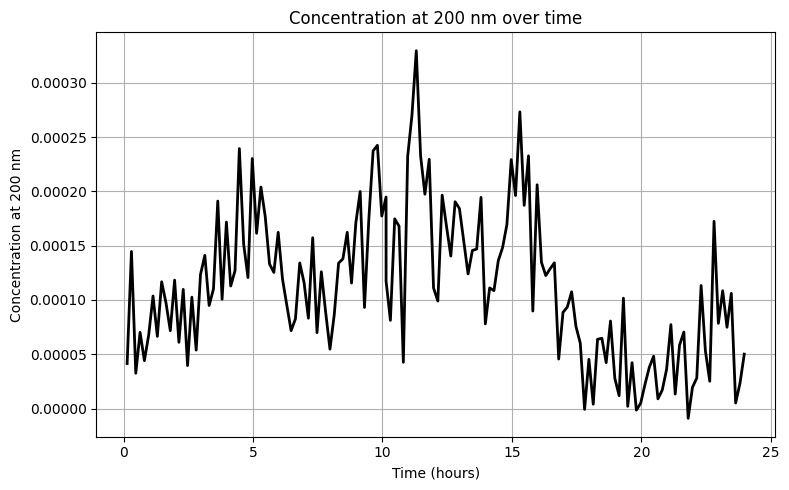

In [23]:
target_wavelength = 200

# find index closest to target
idx = np.argmin(np.abs(x - target_wavelength))

# find absorbance at specified wavelength
times = []
conc_values = []

for file in exp_files:
    x, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs_spectrum = -np.log10((I - I_background) / (I_ref - I_background))
    time_seconds = extract_time_seconds(os.path.basename(file))
    times.append(time_seconds / 3600)  # convert to hours
    conc = abs_spectrum[idx] / (74*1)  # Beer Lambert law to find concentration
    conc_values.append(conc)
    

# === Plot kinetics
plt.figure(figsize=(8, 5))
plt.plot(times, conc_values, '-', color='black', lw=2)
plt.xlabel('Time (hours)')
plt.ylabel(f'Concentration at {target_wavelength} nm')
plt.title(f'Concentration at {target_wavelength} nm over time')
plt.grid(True)
plt.tight_layout()
plt.show()

## Absorbance plot with normalisation (400 nm = 1), + smoothing

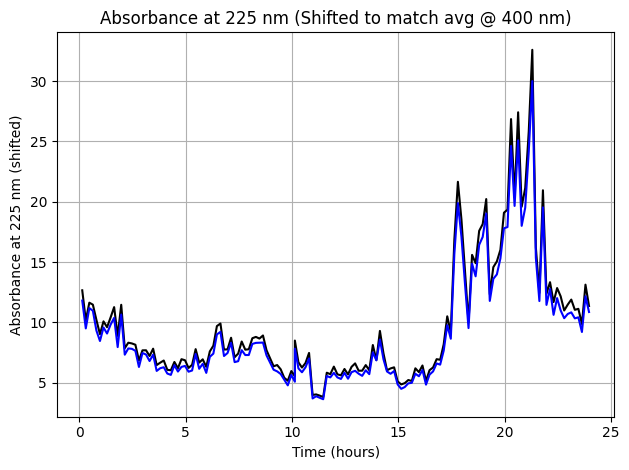

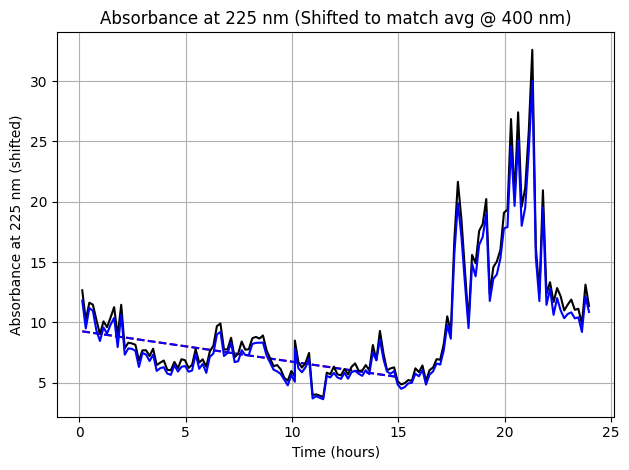

Linear Fit: slope = -0.2551 , intercept = 9.2895
Smoothed linear Fit: slope = -0.2362 , intercept = 8.6945


In [25]:
target_wavelength = 225  # nm

# Find indices for 400 nm and target wavelength
idx_400 = np.argmin(np.abs(x - 400))
idx_target = np.argmin(np.abs(x - target_wavelength))

# Prepare absorbance traces and values at 400 nm
times = []
abs_traces = []
abs_at_400_list = []

# Plot scaled absorbance traces

for file in exp_files:
    x, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs_trace = -np.log10((I - I_background) / (I_ref - I_background))
    abs_traces.append(abs_trace)
    abs_at_400_list.append(abs_trace[idx_400])
    
    time_seconds = extract_time_seconds(os.path.basename(file))
    times.append(time_seconds / 3600)  # convert to hours

# Compute average absorbance at 400 nm
avg_abs_400 = np.mean(abs_at_400_list)

# Compute shifted absorbance at target wavelength (e.g. 200 nm)
conc_values_sm = []
conc_values = []
for abs_trace, abs_400 in zip(abs_traces, abs_at_400_list):
    # shift = avg_abs_400 - abs_400
    abs_shifted = abs_trace/abs_400
    
    ### Unsmoothed plot
    conc = abs_shifted[idx_target] #/ (74*1) # beer lambert law
    conc_values.append(conc)
    
    ### SMOOTHING
    window_length = min(81, len(abs_shifted) // 2 * 2 + 1)  # dynamically determine suitable window
    abs_scaled_smooth = savgol_filter(abs_shifted, window_length=window_length, polyorder=3)
    conc_sm = abs_scaled_smooth[idx_target] #/ (74*1) # beer lambert law
    conc_values_sm.append(conc_sm)

# original plot - unsmoothed
plt.plot(times, conc_values, marker=None, color = 'black')
plt.plot(times, conc_values_sm, marker=None, color='blue')
plt.xlabel('Time (hours)')
plt.ylabel(f'Absorbance at {target_wavelength} nm (shifted)')
plt.title(f'Absorbance at {target_wavelength} nm (Shifted to match avg @ 400 nm)')
plt.grid(True)
plt.tight_layout()
plt.show()
    
########## FIT ###########
# plt.figure()
# plt.plot(times, conc_values, label='Data', color='black')
    
# # Linear fit
# fit_params = np.polyfit(times, conc_values, 1)  # degree 1 for linear
# fit_line = np.poly1d(fit_params)
# fit_values = fit_line(times)

# # Plot the linear fit
# plt.plot(times, fit_values, label=f'Linear fit: y = {fit_params[0]:.4f}x + {fit_params[1]:.4f}', linestyle='--', color='red')

########## FIT only for 0-15 hours ###########
times_arr = np.array(times)
conc_arr = np.array(conc_values)

mask = times_arr <= 15
times_fit = times_arr[mask]
conc_fit = conc_arr[mask]

# Perform linear fit on the subset
fit_params = np.polyfit(times_fit, conc_fit, 1)  # degree 1 for linear
fit_line = np.poly1d(fit_params)
fit_values = fit_line(times_fit)

# linear fit on smoothed data
conc_sm_arr = np.array(conc_values_sm)
conc_sm_fit = conc_sm_arr[mask]
fit_sm_params = np.polyfit(times_fit, conc_sm_fit, 1)  # degree 1 for linear
fit_sm_line = np.poly1d(fit_sm_params)
fit_sm_values = fit_line(times_fit)

# Plot the linear fit (only for 0–15 hours)
plt.plot(times_fit, fit_values, label=f'Linear fit (0–15h): y = {fit_params[0]:.4f}x + {fit_params[1]:.4f}', 
         linestyle='--', color='red')
plt.plot(times_fit, fit_sm_values, label=f'Smoothed linear fit (0–15h): y = {fit_params[0]:.4f}x + {fit_params[1]:.4f}', 
         linestyle='--', color='blue')

# first derivative
# d_conc_dt = np.gradient(conc_arr, times_arr)  # d(conc)/dt

# # Plot linear fit 
# plt.figure()
plt.plot(times, conc_values, marker=None, color = 'black')
plt.plot(times, conc_values_sm, marker=None, color = 'blue')
plt.xlabel('Time (hours)')
plt.ylabel(f'Absorbance at {target_wavelength} nm (shifted)')
plt.title(f'Absorbance at {target_wavelength} nm (Shifted to match avg @ 400 nm)')
plt.grid(True)
plt.tight_layout()
plt.show()

slope, intercept = fit_params
slope_sm, intercept_sm = fit_sm_params
print(f"Linear Fit: slope = {slope:.4f} , intercept = {intercept:.4f}")
print(f"Smoothed linear Fit: slope = {slope_sm:.4f} , intercept = {intercept_sm:.4f}")

# ######

## Concentration plot with normalisation to 400 nm avg (additive)

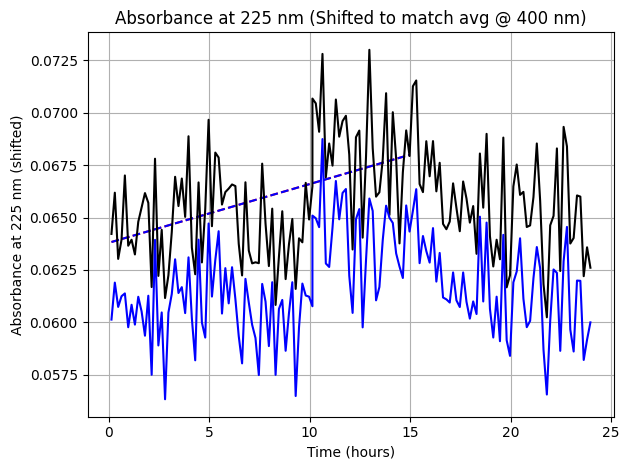

Linear Fit: slope = 0.000280 , intercept = 0.0638
Smoothed linear Fit: slope = 0.000278 , intercept = 0.0597


In [27]:
target_wavelength = 225  # nm

# Find indices for 400 nm and target wavelength (e.g. 220 nm)
idx_400 = np.argmin(np.abs(x - 400))
idx_target = np.argmin(np.abs(x - target_wavelength))

# Prepare absorbance traces and values at 400 nm
times = []
abs_traces = []
abs_at_400_list = []

for file in exp_files:
    x, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs_trace = -np.log10((I - I_background) / (I_ref - I_background))
    abs_traces.append(abs_trace)
    abs_at_400_list.append(abs_trace[idx_400])
    
    time_seconds = extract_time_seconds(os.path.basename(file))
    times.append(time_seconds / 3600)  # convert to hours

# Compute average absorbance at 400 nm
avg_abs_400 = np.mean(abs_at_400_list)

# Compute shifted absorbance at target wavelength (e.g. 200 nm)
conc_values = []
conc_values_sm = []
for abs_trace, abs_400 in zip(abs_traces, abs_at_400_list):
    shift = avg_abs_400 - abs_400
    abs_shifted = abs_trace + shift
    
    conc = abs_shifted[idx_target] # / (74*1) # beer lambert law
    conc_values.append(conc)
    
    window_length = min(81, len(abs_shifted) // 2 * 2 + 1)  # dynamically determine suitable window
    abs_scaled_smooth = savgol_filter(abs_shifted, window_length=window_length, polyorder=3)
    conc_sm = abs_scaled_smooth[idx_target]
    conc_values_sm.append(conc_sm)
    
########## FIT only for 0-15 hours ###########
times_arr = np.array(times)
mask = times_arr <= 15
times_fit = times_arr[mask]

# linear fit unsmoothed
conc_arr = np.array(conc_values)
conc_fit = conc_arr[mask]
fit_params = np.polyfit(times_fit, conc_fit, 1)  # degree 1 for linear
fit_line = np.poly1d(fit_params)
fit_values = fit_line(times_fit)

# linear fit on smoothed data
conc_sm_arr = np.array(conc_values_sm)
conc_sm_fit = conc_sm_arr[mask]
fit_sm_params = np.polyfit(times_fit, conc_sm_fit, 1)  # degree 1 for linear
fit_sm_line = np.poly1d(fit_sm_params)
fit_sm_values = fit_line(times_fit)

# Plot the linear fit (only for 0–15 hours)
plt.plot(times_fit, fit_values, label=f'Linear fit (0–15h): y = {fit_params[0]:.4f}x + {fit_params[1]:.4f}', 
         linestyle='--', color='red')
plt.plot(times_fit, fit_sm_values, label=f'Smoothed linear fit (0–15h): y = {fit_params[0]:.4f}x + {fit_params[1]:.4f}', 
         linestyle='--', color='blue')

# Plot kinetics
# plt.figure()
plt.plot(times, conc_values, marker=None, color = 'black')
plt.plot(times, conc_values_sm, marker=None, color = 'blue')
plt.xlabel('Time (hours)')
plt.ylabel(f'Absorbance at {target_wavelength} nm (shifted)')
plt.title(f'Absorbance at {target_wavelength} nm (Shifted to match avg @ 400 nm)')
plt.grid(True)
plt.tight_layout()
plt.show()

slope, intercept = fit_params
slope_sm, intercept_sm = fit_sm_params
print(f"Linear Fit: slope = {slope:.6f} , intercept = {intercept:.4f}")
print(f"Smoothed linear Fit: slope = {slope_sm:.6f} , intercept = {intercept_sm:.4f}")

## Gradient plots

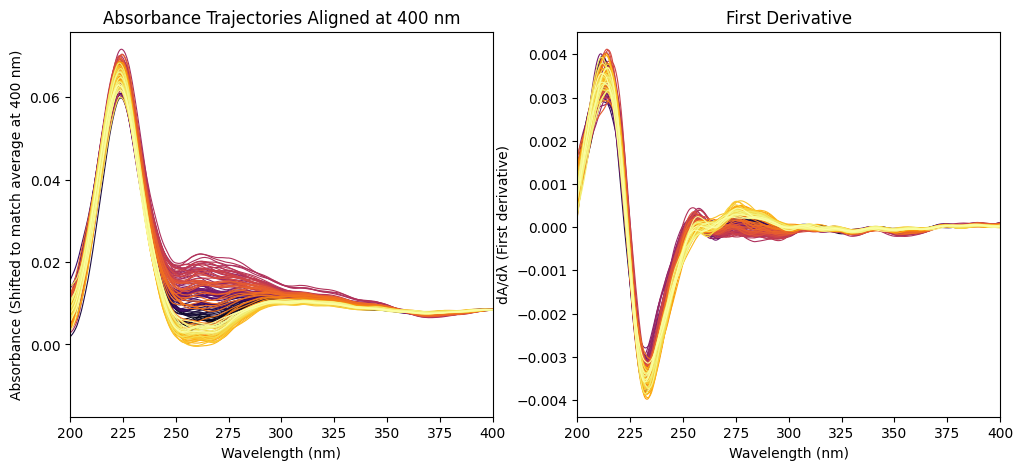

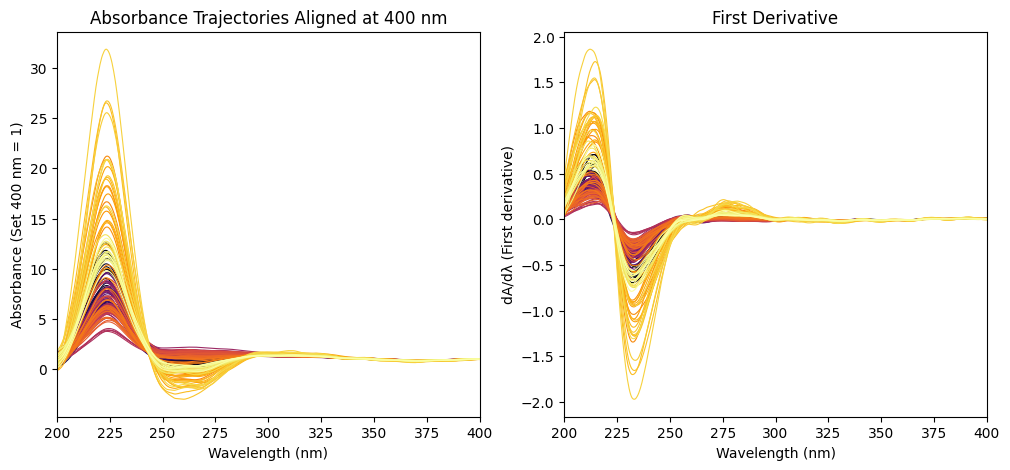

In [29]:
# gradient in range:
# lambda_start = 200
# lambda_end = 400

# Find indices corresponding to range
# idx_start = np.argmin(np.abs(x - lambda_start))
# idx_end = np.argmin(np.abs(x - lambda_end)) + 1  # +1 to include lambda_end

times = [extract_time_seconds(os.path.basename(f)) for f in exp_files]
# Prepare lists
abs_traces = []
abs_at_400_list = []
gradients_225_230 = []

for file in exp_files:
    x, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs_trace = -np.log10((I - I_background) / (I_ref - I_background))
    abs_traces.append(abs_trace)
    abs_at_400_list.append(abs_trace[idx_400])

# Compute average absorbance at 400 nm
avg_abs_400 = np.mean(abs_at_400_list)

# Plot setup
norm = Normalize(vmin=min(times), vmax=max(times))
cmap = colormaps['inferno']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Loop to align, smooth, extract gradients, and plot
for abs_trace, t, abs_400 in zip(abs_traces, times, abs_at_400_list):
    #### ADDITIVE NORMALISATION
    shift = avg_abs_400 - abs_400
    abs_shifted = abs_trace + shift
    
    ###
    # abs_shifted = abs_trace/abs_400

    # Savitzky-Golay smoothing
    window_length = min(51, len(abs_shifted) // 2 * 2 + 1)
    abs_smooth = savgol_filter(abs_shifted, window_length=window_length, polyorder=3)

#     # Store gradient in 225–230 nm region
#     x_region = x[idx_start:idx_end]
#     y_region = abs_smooth[idx_start:idx_end]

#     # Linear fit: gradient = slope of best-fit line
#     coeffs = np.polyfit(x_region, y_region, 1)
#     gradient = coeffs[0]
#     gradients_225_230.append(gradient)

    # Compute first derivative with respect to wavelength
    d_abs_d_lambda = np.gradient(abs_smooth, x)
    d_abs_d_lambda_smooth = savgol_filter(d_abs_d_lambda, window_length=window_length, polyorder=3)

    # Plot smoothed curve
    ax1.plot(x, abs_smooth, color=cmap(norm(t)), lw=0.8)
    
    # Plot derivative vs wavelength
    ax2.plot(x, d_abs_d_lambda_smooth, color=cmap(norm(t)), lw=0.8)

# Add colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=ax, label='Elapsed Time (hrs)')
tick_vals = np.linspace(min(times), max(times), 6)
tick_labels = [f"{t/3600:.1f}" for t in tick_vals]
cbar.set_ticks(tick_vals)
cbar.set_ticklabels(tick_labels)

# Plot settings
ax1.set_xlim(200.0, 400.0)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Absorbance (Shifted to match average at 400 nm)')
ax1.set_title('Absorbance Trajectories Aligned at 400 nm')

# Plot settings
ax2.set_xlim(200.0, 400.0)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('dA/dλ (First derivative)')
ax2.set_title('First Derivative')
plt.show()


################################
## NORMALISATION 400 nm = 1 
################################

times = [extract_time_seconds(os.path.basename(f)) for f in exp_files]
# Prepare lists
abs_traces = []
abs_at_400_list = []
gradients_225_230 = []

for file in exp_files:
    x, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs_trace = -np.log10((I - I_background) / (I_ref - I_background))
    abs_traces.append(abs_trace)
    abs_at_400_list.append(abs_trace[idx_400])

# Compute average absorbance at 400 nm
avg_abs_400 = np.mean(abs_at_400_list)

# Plot setup
norm = Normalize(vmin=min(times), vmax=max(times))
cmap = colormaps['inferno']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Loop to align, smooth, extract gradients, and plot
for abs_trace, t, abs_400 in zip(abs_traces, times, abs_at_400_list):
    abs_shifted = abs_trace/abs_400

    # Savitzky-Golay smoothing
    window_length = min(51, len(abs_shifted) // 2 * 2 + 1)
    abs_smooth = savgol_filter(abs_shifted, window_length=window_length, polyorder=3)

    # Compute first derivative with respect to wavelength
    d_abs_d_lambda = np.gradient(abs_smooth, x)
    d_abs_d_lambda_smooth = savgol_filter(d_abs_d_lambda, window_length=window_length, polyorder=3)

    # Plot smoothed curve
    ax1.plot(x, abs_smooth, color=cmap(norm(t)), lw=0.8)
    
    # Plot derivative vs wavelength
    ax2.plot(x, d_abs_d_lambda_smooth, color=cmap(norm(t)), lw=0.8)

# Add colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=ax, label='Elapsed Time (hrs)')
tick_vals = np.linspace(min(times), max(times), 6)
tick_labels = [f"{t/3600:.1f}" for t in tick_vals]
cbar.set_ticks(tick_vals)
cbar.set_ticklabels(tick_labels)

# Plot settings
ax1.set_xlim(200.0, 400.0)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Absorbance (Set 400 nm = 1)')
ax1.set_title('Absorbance Trajectories Aligned at 400 nm')

# Plot settings
ax2.set_xlim(200.0, 400.0)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('dA/dλ (First derivative)')
ax2.set_title('First Derivative')
plt.show()


Band averaging

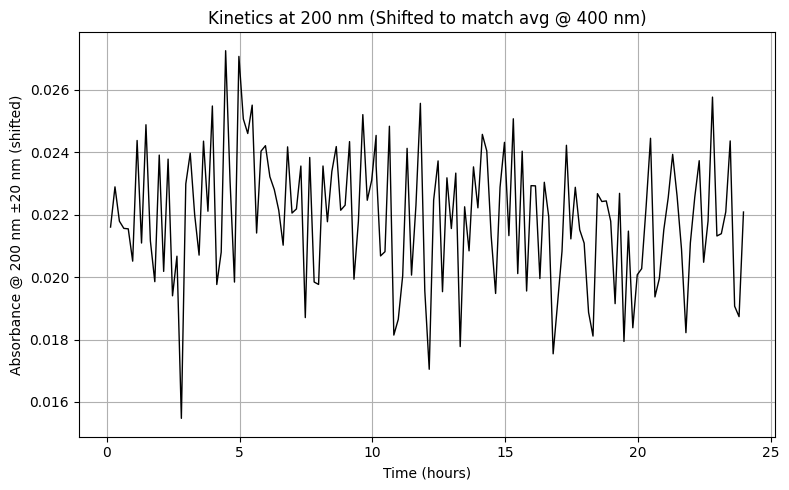

In [31]:
# === PARAMETERS ===
# exp_folder = './24hr_27052025'
# skip = 40  # header rows to skip in files
center_wavelength = 200  # nm
band_half_width = 20      # +/- nm for averaging
normalisation_wavelength = 400  # nm

# load files
exp_files = [f for f in glob.glob(f'{exp_folder}/*.txt') if '24HourExp' in f]
exp_files.sort(key=lambda f: extract_time_seconds(os.path.basename(f)))
times_sec = [extract_time_seconds(os.path.basename(f)) for f in exp_files]

# background and reference
# I_background = I_ref = None
# for file in glob.glob(f'{exp_folder}/*.txt'):
#     if 'Background' in file:
#         x, I_background = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
#     elif 'Reference' in file:
#         _, I_ref = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)

# if I_background is None or I_ref is None:
#     raise RuntimeError("Reference or background file not found.")

# index of normalisation wavelength 
idx_norm = np.argmin(np.abs(x - normalisation_wavelength))

# calculate average absorbance at normalisation wavelength
abs_at_400_list = []
for file in exp_files:
    _, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs_trace = -np.log10((I - I_background) / (I_ref - I_background))
    abs_at_400_list.append(abs_trace[idx_norm])
avg_abs_at_400 = np.mean(abs_at_400_list)

# Extract absorbance at target wavelength band and shift
abs_values = []
for file in exp_files:
    _, I = np.loadtxt(file, skiprows=skip, usecols=(0, 1), unpack=True)
    abs_trace = -np.log10((I - I_background) / (I_ref - I_background))
    
    shift_val = abs_trace[idx_norm] - avg_abs_at_400
    abs_shifted = abs_trace - shift_val

    avg_abs = band_averaged_absorbance(x, abs_shifted, center_nm=center_wavelength, band_half_width=band_half_width)
    abs_values.append(avg_abs)

# Convert times to hours for plotting
times_hrs = np.array(times_sec) / 3600

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(times_hrs, abs_values, color='black', lw=1)
plt.xlabel("Time (hours)")
plt.ylabel(f"Absorbance @ {center_wavelength} nm ±{band_half_width} nm (shifted)")
plt.title(f"Kinetics at {center_wavelength} nm (Shifted to match avg @ {normalisation_wavelength} nm)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Experiment 2

Loaded reference: 20250626_Reference_water_MAYP1162681_15-54-55-008.txt, shape = (2068,)
Loaded background: TooManySpectrometers_Background_MAYP1162682_17-34-18-531.txt, shape = (2068,)


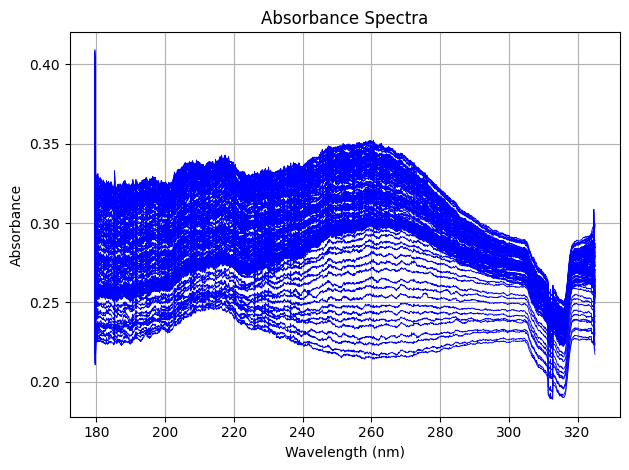

In [33]:
exp_folder = './20250626_exp2'
# exp_folder = './20250527_exp1'

def load_spectral_data(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    # Find the first line that looks like real data (2 floats)
    for i, line in enumerate(lines):
        parts = line.strip().split()
        if len(parts) >= 2:
            try:
                float(parts[0])
                float(parts[1])
                data_start = i
                break
            except ValueError:
                continue
    else:
        raise ValueError(f"Could not find data in file: {filepath}")

    # Now load the data starting from the first valid line
    data = np.loadtxt(lines[data_start:], usecols=(0, 1))
    return data[:, 0], data[:, 1]

# Initialize holders
I_background = None
I_ref = None
x_ref = None

# Load reference and background
for file in glob.glob(f'{exp_folder}/*.txt'):
    fname = os.path.basename(file)
    if 'Background' in fname:
        x_b, I_background = load_spectral_data(file)
        print(f"Loaded background: {fname}, shape = {I_background.shape}")
    elif 'Reference' in fname and 'end' not in fname:
        x_ref, I_ref = load_spectral_data(file)
        print(f"Loaded reference: {fname}, shape = {I_ref.shape}")

# check
if I_background is None or I_ref is None:
    raise ValueError("Missing background or reference data.")

# Ensure background is same shape — interpolate if needed (not strictly necessary if wavelengths match)
if I_background.shape != I_ref.shape:
    print(f"Interpolating background from shape {I_background.shape} to match {I_ref.shape}")
    I_background = np.interp(x_ref, x_b, I_background)

# Process absorbance files
for file in glob.glob(f'{exp_folder}/*.txt'):
    fname = os.path.basename(file)
    if 'Reference' in fname or 'Background' in fname or 'AbsoluteIrradiance' in fname:
        continue  # skip these

    x, I = load_spectral_data(file)
    if I.shape != I_ref.shape:
        print(f"Skipping {fname} due to shape mismatch: {I.shape} vs {I_ref.shape}")
        continue

    # Absorbance calculation
    abs = -np.log10((I - I_background) / (I_ref - I_background))
    plt.plot(x, abs,'b-', label=fname, lw=0.6)

# plt.xlim(200.0,400.0)
# plt.ylim(-0.02,0.1)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title("Absorbance Spectra")
plt.grid(True)
# plt.legend(fontsize=6)
plt.tight_layout()
plt.show()

Loaded reference: 20250626_Reference_water_MAYP1162681_15-54-55-008.txt, shape = (2068,)
Loaded background: TooManySpectrometers_Background_MAYP1162682_17-34-18-531.txt, shape = (2068,)
Average absorbance at 320: 0.27135048357762154


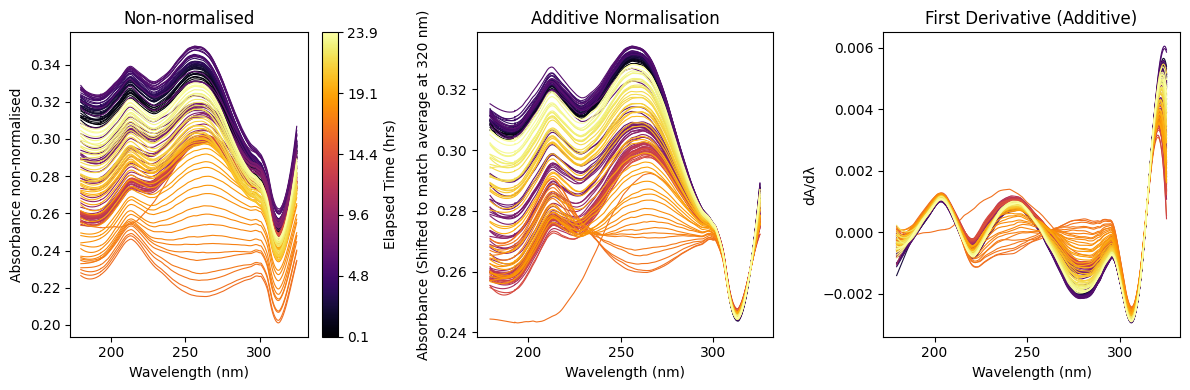

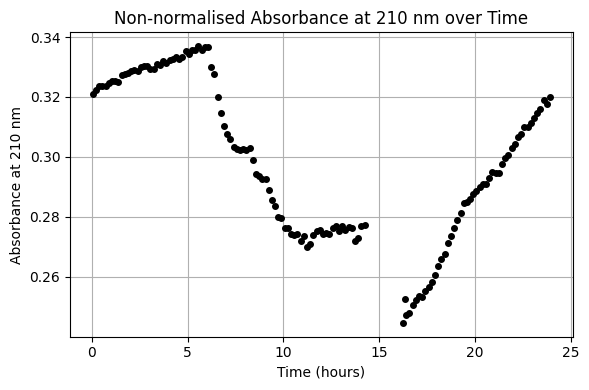

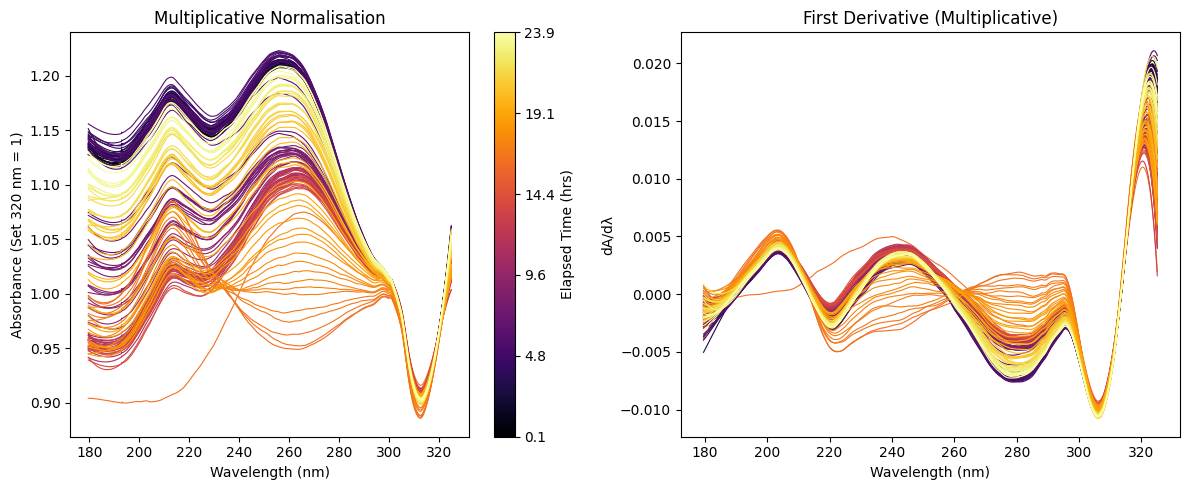

In [34]:
# normalisation wavelength
norm_lambda = 320

# ========== Helper Function to Load Spectral Data ==========
def load_spectral_data(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()

    # Find first line with valid float data (2 columns)
    for i, line in enumerate(lines):
        parts = line.strip().split()
        if len(parts) >= 2:
            try:
                float(parts[0])
                float(parts[1])
                data_start = i
                break
            except ValueError:
                continue
    else:
        raise ValueError(f"No valid data found in {filepath}")

    data = np.loadtxt(lines[data_start:], usecols=(0, 1))
    return data[:, 0], data[:, 1]

# ========== Utility to Extract Time from Filename ==========
def extract_time_seconds(filename):
    # Extracts time in HH-MM-SS from filename and converts to seconds
    try:
        parts = filename.split('_')[-1].split('.')[0].split('-')
        h, m, s = map(int, parts[:3])
        return h * 3600 + m * 60 + s
    except:
        return 0  # Fallback if format is unexpected

# ========== Load Background and Reference ==========
data_folder = './20250626_exp2'
files = glob.glob(f"{data_folder}/*.txt")

I_background = I_ref = x_ref = None

for file in files:
    fname = os.path.basename(file)
    if 'Background' in fname:
        x_b, I_background = load_spectral_data(file)
    # if 'AbsoluteIrradiance' in fname:
        # x_b, I_background = load_spectral_data(file)
        print(f"Loaded background: {fname}, shape = {I_background.shape}")
    elif 'Reference' in fname and 'end' not in fname:
        x_ref, I_ref = load_spectral_data(file)
        print(f"Loaded reference: {fname}, shape = {I_ref.shape}")

# Sanity check
if I_background is None or I_ref is None:
    raise RuntimeError("Background or Reference file missing")

# Ensure all share the same x-axis (wavelengths)
x = x_ref
if not np.allclose(x, x_b[:len(x)], rtol=1e-4):
    raise ValueError("Wavelength mismatch between reference and background")

# ========== Get All Experiment Files ==========
exp_files = [f for f in files if 'Reference' not in f and 'Background' not in f and 'AbsoluteIrradiance' not in f]

# ========== Pre-calculate Indexes ==========
idx_norm = np.argmin(np.abs(x - norm_lambda))
# idx_start = np.argmin(np.abs(x - 225))
# idx_end = np.argmin(np.abs(x - 230))

# ========== Extract Absorbance Traces ==========
times = [extract_time_seconds(os.path.basename(f)) for f in exp_files]
abs_traces = []
abs_at_norm_list = []

for file in exp_files:
    x_i, I = load_spectral_data(file)
    if not np.allclose(x, x_i[:len(x)], rtol=1e-4):
        raise ValueError(f"Wavelength mismatch in file: {file}")
    abs_trace = -np.log10((I[:len(x)] - I_background[:len(x)]) / (I_ref[:len(x)] - I_background[:len(x)]))
    abs_traces.append(abs_trace)
    abs_at_norm_list.append(abs_trace[idx_norm])

avg_abs_norm = np.mean(abs_at_norm_list)
norm = Normalize(vmin=min(times), vmax=max(times))
cmap = colormaps['inferno']

# ========== PLOT 1: Additive Normalisation to MATCH absorbance at chosen wavelength ==========
abs_at_norm_list = [trace[idx_norm] for trace in abs_traces]
avg_abs_norm = np.nanmean(abs_at_norm_list)

# avg_abs_norm = np.mean(abs_at_norm_list)
# print(abs_at_norm_list)
print(f"Average absorbance at {norm_lambda}:", avg_abs_norm)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True)

for abs_trace, t, abs_norm in zip(abs_traces, times, abs_at_norm_list):
    shift = avg_abs_norm - abs_norm  # shift to match average at chosen wavelength
    abs_shifted = abs_trace + shift

    window_length = min(351, len(abs_shifted) // 2 * 2 + 1)
    abs_smooth = savgol_filter(abs_shifted, window_length=window_length, polyorder=3)
    d_abs_d_lambda = np.gradient(abs_smooth, x)
    
    abs_trace_smooth = savgol_filter(abs_trace, window_length=window_length, polyorder=3)
    d_abs_d_lambda_smooth = savgol_filter(d_abs_d_lambda, window_length=window_length, polyorder=3)
    
    ax1.plot(x, abs_trace_smooth, color=cmap(norm(t)), lw=0.8)
    ax2.plot(x, abs_smooth, color=cmap(norm(t)), lw=0.8)
    # ax3.plot(x, d_abs_d_lambda, color=cmap(norm(t)), lw=0.8)
    ax3.plot(x, d_abs_d_lambda_smooth, color=cmap(norm(t)), lw=0.8)


# Colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=ax1, label='Elapsed Time (hrs)')
tick_vals = np.linspace(min(times), max(times), 6)
tick_labels = [f"{t/3600:.1f}" for t in tick_vals]
cbar.set_ticks(tick_vals)
cbar.set_ticklabels(tick_labels)

ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Absorbance non-normalised')
ax1.set_title('Non-normalised')

# ax2.set_xlim(200.0, 400.0)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel(f'Absorbance (Shifted to match average at {norm_lambda} nm)')
ax2.set_title('Additive Normalisation')

# ax3.set_xlim(200.0, 400.0)
ax3.set_xlabel('Wavelength (nm)')
ax3.set_ylabel('dA/dλ')
ax3.set_title('First Derivative (Additive)')

plt.tight_layout()
plt.show()

######################################################################
# ========== Plot Absorbance at Target Wavelength over Time ==========

target_wavelength = 210  # nm
idx_target = np.argmin(np.abs(x - target_wavelength))

# Convert time to hours
times_hours = np.array(times) / 3600

# Extract absorbance at target wavelength (non-normalised)
abs_at_target = [trace[idx_target] for trace in abs_traces]

# New figure for time series plot
plt.figure(figsize=(6, 4))
plt.plot(times_hours, abs_at_target, 'ko', ms=4)
plt.xlabel('Time (hours)')
plt.ylabel(f'Absorbance at {target_wavelength} nm')
plt.title(f'Non-normalised Absorbance at {target_wavelength} nm over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

########################################################################################
# ========== PLOT 2: Multiplicative Normalisation (Set absorbance at X nm = 1) ==========
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

for abs_trace, t, abs_norm in zip(abs_traces, times, abs_at_norm_list):
    abs_scaled = abs_trace / abs_norm  # Scale such that value at norm wavelength becomes 1

    window_length = min(351, len(abs_scaled) // 2 * 2 + 1)
    abs_smooth = savgol_filter(abs_scaled, window_length=window_length, polyorder=3)
    d_abs_d_lambda = np.gradient(abs_smooth, x)
    d_abs_d_lambda_smooth = savgol_filter(d_abs_d_lambda, window_length=window_length, polyorder=3)

    ax1.plot(x, abs_smooth, color=cmap(norm(t)), lw=0.8)
    ax2.plot(x, d_abs_d_lambda_smooth, color=cmap(norm(t)), lw=0.8)

# Colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=ax1, label='Elapsed Time (hrs)')
cbar.set_ticks(tick_vals)
cbar.set_ticklabels(tick_labels)

# ax1.set_xlim(200.0, 400.0)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel(f'Absorbance (Set {norm_lambda:.0f} nm = 1)')
ax1.set_title('Multiplicative Normalisation')

# ax2.set_xlim(200.0, 400.0)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('dA/dλ')
ax2.set_title('First Derivative (Multiplicative)')
plt.tight_layout()
plt.show()

In [35]:
# from NIST database 3.10 - for molar absorbtivity
# https://webbook.nist.gov/cgi/cbook.cgi?ID=C57136&Mask=400#UV-Vis-Spec
